# Lab Six: Convolutional Network Architectures

#### Machine Learning in Python
    
Will Lacey - 45906124 - <strong>CSE7324</strong>
<br>
Roger Wong - 43867412 - <strong>CSE5324</strong>

## ASL Alphabet
#### Image data set for alphabets in the American Sign Language

<img src='NIDCD-ASL-hands-2014.jpg' width="250">

For this lab, we again selected the American Sign Language Dataset. This time around, we plan to use the entire dataset, which is made up of 29 classes, each with a total of 3000 images. The ASL dataset includes the alphabet and three additional classes (del, space, and nothing).

Now that we understand better image processing techniques, we hope to accomplish a higher accuracy than we did before.

#### Import Modules and Initialization

Before we begin, let's import essential packages for data analysis

In [1]:
import keras
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average, concatenate
from keras.models import Input, Model
from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add
from keras.models import Sequential

import matplotlib
from matplotlib import pyplot as plt

import numpy as np

from PIL import Image

import random
from random import randint

import seaborn as sns
sns.set(style='darkgrid')

import skimage.transform
# from skimage.io import imshow

import sklearn
import sklearn.datasets
from sklearn import metrics as mt
from sklearn.metrics import roc_curve, auc, accuracy_score

import sys

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

Using TensorFlow backend.


## Preparation (30 points total)

Okay. First, let's declare a function to load, transform, and normalize images from the <strong>asl_alphabet</strong> dataset. Because we are loading our data with PIL, our images will be normalized upon loading.

In [2]:
def load_images(asl_classes, count, size):
    img_list = []
    for class_name in asl_classes:
        for i in range(count):
            img_path_string = 'asl_alphabet_train/'+class_name+'/'+class_name+str(i+1)+'.jpg'
            img = np.asarray(Image.open(img_path_string))
            img = skimage.transform.resize(img, (size, size), mode='constant') # resizes image
            img_list.append(img)
        sys.stderr.write('\rClass %s done' % class_name)
        sys.stderr.flush()
    return img_list

Now that our function is defined, we can go grab the images. This takes a little more than a minute.

In [3]:
%%time

number_of_images = 3000

img_size = 32

asl_classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
               'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 
               'del', 'space', 'nothing'
]

data_list = load_images(asl_classes, number_of_images, img_size)

Class nothing done

Wall time: 13min 24s


Here, we capture the class titles for each image and additionally convert them to numeric values. This will be useful later on for encoding our images in the neural networks and classifying them.

In [4]:
# Gather Class Titles
data_class = []
for i in range(len(asl_classes)):
    for j in range(number_of_images):
        data_class.append(asl_classes[i])
        
# Convert Class Titles to Values
data_value = []
for i in range(len(data_class)):
    data_value.append(asl_classes.index(data_class[i]))

Pause. Let's take a quick look at our different classes using our <strong>plot_gallery</strong> function from Lab2.

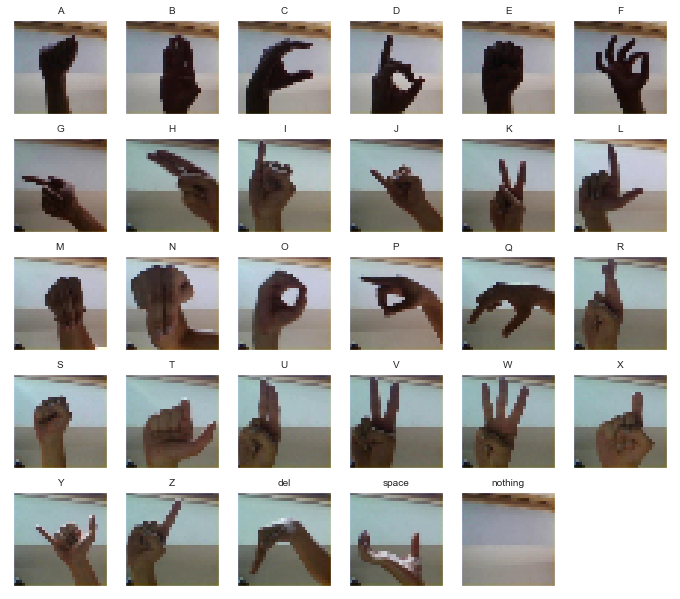

In [5]:
# a similar plotting function as seen in class; selects images from dataset
def plot_gallery(images, titles, class_count=29, random=False, n_row=5, n_col=6):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.9, top=.70, hspace=.1)
    for i in range(n_row * n_col):
        if i != (n_row * n_col - 1):
            plt.subplot(n_row, n_col, i + 1)
            if random:
                index = randint(1, len(images)-1)
            else:
                index =int(i * len(images) / class_count)
            plt.imshow(images[index])
            plt.title(titles[index], size=10)
            plt.xticks(())
            plt.yticks(())

        
plot_gallery(images=data_list, titles=data_class) 

In observing our different hand signs, we notice that several of the classes are similar. Most notably, we see that the similarity between A, E, and S, as well as M and N make the classes difficult to differentiate. Additionally, classes R, U and X along with G and H are not the easiest to decipher as well. Ideally, our classifier will be able to pick up these minute details and deliver a confident accuracy.

<em> 
<strong> [15 points] </strong>Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
</em>

For our dataset, the evaluation metric we selected was an accuracy score. While it is true that accuracy is rarely the best evaluation metric to use, we believed it would be the best for our dataset because of a few reasons. First, the American Sign Language alphabet would be normally used for spelling words or names in the midst of a conversation. Although the English language does not use each letter in the alphabet equally, the impetus for using the ASL alphabet would most likely be to spell a name or a unique word, which would follow a different trend than the distribution of the alphabet seen normally throughout the English dictionary and vernacular. In this vein, we really wouldn’t have favoritism over any particular letter or class, and as a result we would then have the luxury to care about each equally. In conjunction with this point, we also have an equal number of each class, which allows us to ignore any special weighting of our evaluation methods. In conclusion, we believe that this gives us the ability to use accuracy score to weigh and measure our algorithms. Through utilizing both an accuracy score and a confusion matrix, we will be able to compare and analyze our networks. 


<em> 
<strong>[15 points]</strong> Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 
</em>


In short, for our cross validation method we are simply shuffling our data and then performing an 80/20 split on it. 

As mentioned before, our dataset has a total of 29 different classes. For every class, the dataset has subdirectory where each subdirectory includes a corresponding set of images that appear to have been stripped from a video. This seems to be the case because each image, labeled 1 to 3000, seems to be highly similar to its numeric neighbor.  For a quick example, image 1000 is very similar in appearance to image 999 and 1001 but less similar to image 1 or 3000. To prevent the model from both seeing very similar, almost duplicate, images and from learning that adjacent images are most likely the same class, we randomly shuffled the data. This makes the input more realistically trainable. 

We decided to do an 80/20 split on our data because after the split we still have 2400 trainable images per class, totaling a sum of 69600 images for the trainable portion of the dataset. This amount of data, we believe, is sufficient to split since it should still capture how our model will perform in actuality. While in deployment the model should train on even more images to raise the accuracy further, the amount we currently have will absolutely suffice in capturing a lower bound of its performance. 


Alright, let's continue preparing the data. Next we'll make our corresponding shuffle and split functions.

In [6]:
def shuffle(data, seed=0):
    """Shuffles the data given a random seed"""
    random.seed(seed)
    random.shuffle(data)
    return data

def split(data, number_of_classes, percentage):
    """Splits data and target into training and testing data based off the split percentage"""

    train = []
    test = []
    number_per_class = int(len(data) / number_of_classes)
    
    for i in range(number_of_classes):
        start = i * number_per_class
        index_split = start + int(percentage * number_per_class)
        end = (i * number_per_class) + number_per_class
        
        train.extend(data[start:index_split])
        test.extend(data[index_split:end])
        
    return train, test

In the next few cells, we are going to create a <strong>sklearn Bunch</strong> object to better organize our data. The object will split the <em>image data</em> along with both the <em>class titles</em> and the <em>encoded class titles</em> of the dataset into <strong>X_train</strong>, <strong>y_train (either class or value)</strong>, <strong>X_test</strong>, and <strong>y_test (either class or value)</strong> numpy arrays. We will also add <strong>y_train_ohe</strong> and <strong>y_test_ohe</strong> to keep track of the one hot encoding of the <em>encoded class titles</em>. In addition, the object will have the numpy array, <strong>y_classes</strong>, as a container for all the various classes of the dataset and, lastly, <strong>img_size</strong>, to keep track of the image dimensions. 

These variables will contain the essential data needed to perform data analysis and training for our neural networks. In further detail, here's a description of each variable within our <strong>sklearn Bunch</strong> object.

##### Training
<ul>
    <li><strong>X_train</strong> - The ASL image training dataset; 2D numpy vectors that have been transformed into <strong>img_size</strong> number of pixels</li>
    <li><strong>y_train_class</strong> - The ASL image training dataset associated class names; each instance is a class name which can be mapped to the corresponding image 2D vector by index</li>
    <li><strong>y_train_value</strong> - The ASL image training dataset associated class values; each instance is a class value which can be mapped to the corresponding image 2D vector and target class by index</li>
    <li><strong>y_train_ohe</strong> - A one-hot-encoding of the <strong>y_train_value</strong> data member</li>
</ul>

##### Testing
<ul>
    <li><strong>X_test</strong> - The ASL image testing dataset; 2D numpy vectors that have been transformed into <strong>img_size</strong> number of pixels</li>
    <li><strong>y_test_class</strong> - The ASL image testing dataset associated class names; each instance is a class name which can be mapped to the corresponding image 2D vector by index</li>
    <li><strong>y_test_value</strong> - The ASL image testing dataset associated class values; each instance is a class value which can be mapped to the corresponding image 2D vector and target class by index</li>
    <li><strong>y_test_ohe</strong> - A one-hot-encoding of the <strong>y_test_value</strong> data member</li>
</ul>

##### Additional Variables
<ul>
    <li><strong>y_classes</strong> - A numpy array of class names present in the ASL image dataset; contains the alphabet and three additional classes</li>
    <li><strong>img_size</strong> - The side dimension (length and width are equal) of each image or 2D vector within the ASL image training dataset</li>
</ul>

This next cell calls our <strong>shuffle</strong> and <strong>split</strong> functions on our data, and creates the <strong>sklearn Bunch</strong> object

In [7]:
# Shuffle Data
random_seed = randint(0, 1000) # Create a random seed for shuffling
data_list = shuffle(data_list, random_seed)
data_class = shuffle(data_class, random_seed)
data_value = shuffle(data_value, random_seed)

# Split Data
percentage = 4/5 # 80, 20 split
data_list_train, data_list_test = split(data_list, len(asl_classes), percentage)
data_class_train, data_class_test = split(data_class, len(asl_classes), percentage)
data_value_train, data_value_test = split(data_value, len(asl_classes), percentage)

# Create sklearn Bunch Object
ds = sklearn.datasets.base.Bunch(
    
    # Load in image data (samples, length, width, channels)
    X_train = np.array(data_list_train),
    
    # Dividing y_train into class names, encoded values (from 0 to 28), and one-hot-encoding
    y_train_class = np.array(data_class_train),
    y_train_value = np.array(data_value_train),
    y_train_ohe = keras.utils.to_categorical(data_value_train, len(asl_classes)),

    # Load in image data (samples, length, width, channels)
    X_test = np.array(data_list_test),
    
    # Dividing y_test into class names, encoded values (from 0 to 28), and one-hot-encoding
    y_test_class = np.array(data_class_test),
    y_test_value = np.array(data_value_test),
    y_test_ohe = keras.utils.to_categorical(data_value_test, len(asl_classes)),
    
    # The Various Class Titles
    y_classes = np.array(asl_classes),
    
    # Length and Width of Images
    img_size = img_size
)

# Printing Dimensions of Object
print('Shape of X_train:', ds.X_train.shape)
print('Shape of y_train \'class\' and \'value\':', ds.y_train_class.shape)
print('Shape of y_train_ohe:', ds.y_train_ohe.shape)
print('Shape of X_test:', ds.X_test.shape)
print('Shape of y_train \'class\' and \'value\':', ds.y_test_value.shape)
print('Shape of y_test_ohe:', ds.y_test_ohe.shape)
print('Shape of y_classes:', ds.y_classes.shape)
print('Length/Width of images:', ds.img_size)

Shape of X_train: (69600, 32, 32, 3)
Shape of y_train 'class' and 'value': (69600,)
Shape of y_train_ohe: (69600, 29)
Shape of X_test: (17400, 32, 32, 3)
Shape of y_train 'class' and 'value': (17400,)
Shape of y_test_ohe: (17400, 29)
Shape of y_classes: (29,)
Length/Width of images: 32


Now that we have stored all our data inside of the object, we are going to delete the previously used data structures that we no longer need. 

In [8]:
del data_list
del data_class_train
del data_class_test
del data_class
del data_value
del data_value_train
del data_value_test
del asl_classes
del img_size

Alright, let's take another look at the images. Now that they're shuffled and split, the images should take a seemingly random order.

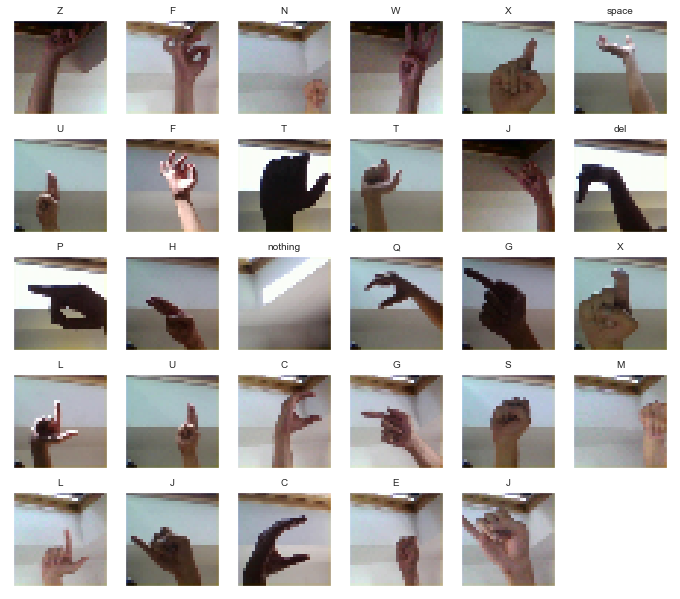

In [11]:
plot_gallery(images=ds.X_train, titles=ds.y_train_class) 

## Modeling (60 points total)

Before we begin modeling, let's create a few functions to fit, predict, track, and display our neural networks.

In [9]:
def network_fit(nn, datagen, X_train, y_train, X_test, y_test, epochs=50, batch_size=32, patience=4, verbose=0):
    """Fits data to a neural network using a specified epoch count and batch size; also 
    utilizes a specified data expansion"""
    history = nn.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                               steps_per_epoch=int(len(X_train)/batch_size),
                               epochs=epochs, 
                               verbose=verbose, 
                               validation_data = (X_test, y_test),
                               callbacks=[EarlyStopping(monitor='val_loss', patience=patience)]
    )
    
    return history

def network_predict(nn, X_test, y_test):
    """Returns an accuracy for a neural network, a confusion matrix, and ROC data"""
    yhat_proba = nn.predict(X_test)
    yhat = np.round(yhat_proba)
    acc = mt.accuracy_score(y_test, yhat)
    fpr, tpr, _ = roc_curve(y_test.flatten(), yhat_proba.flatten())
    roc_auc = auc(fpr, tpr)
    return acc, fpr, tpr, roc_auc

def network_plot(history):    
    """Visualizes the performance of the training and validation sets per epoch"""
    plt.figure(figsize=(15,5))

    # summarize history for accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.show()

def network_summarize(net, X_test, y_test, title_text=''):
    """This function is similar to the one seen in class; visualizes the confusion matrix"""
    plt.figure(figsize=(15,10))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))

Let's also create a couple variables for training.

In [10]:
epochs = 300
batch_size = 128
patience = 5
verbose = 1

<em> 
    <strong>[15 points]</strong> Create a convolutional neural network to use on your data using Keras. Setup the training to use data expansion in Keras. Explain why the chosen data expansion techniques are appropriate for your dataset. 
</em>

In this cell, we implement data expansion through Keras's ImageDataGenerator as seen in lecture. We utilized a 10% width and height shift in our images along with a 5º rotational transform. These parameters we copied from class because we saw them fit for our dataset and images. These mutations allow for change in the images without losing the integrity of the class. Any shift or rotation larger than these thresholds threaten losing essential information in the images.

In [11]:
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)

datagen.fit(ds.X_train)

For our first convolutional neural network, we created an architecture where we utilized a 2 by 2 convolutional filter and maxpool. The entire architecture consists of three convolutional layers and then a fully connected multilayer perceptron with three dense layers. At every activation except for the final layer, we implement ReLu to handle vanishing gradients. Let's see how it does.

In [16]:
num_filt_layers = [32,64,64]

inputs = Input(shape=ds.X_test[0].shape, name='Input')
x = inputs
for num_filt in num_filt_layers:
    x = Conv2D(filters=num_filt,
               kernel_size=(2,2),
               padding='same', 
               input_shape=ds.X_test[0].shape,
               data_format="channels_last")(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(len(ds.y_classes), activation='softmax')(x) 

cnn = Model(inputs=inputs, outputs=predictions)

cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        416       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_

Above is a print out of our <strong>CNN</strong>'s architecture. Now that our model has been built, we can pass our <strong>CNN</strong> on to our <strong>network_fit</strong> function to train our model on our training data.

In [16]:
%%time

history = network_fit(cnn, 
                      datagen, 
                      ds.X_train, 
                      ds.y_train_ohe, 
                      ds.X_test, 
                      ds.y_test_ohe, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      patience=patience, 
                      verbose=verbose
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/300
543/543 [==============================] - 91s 167ms/step - loss: 0.0286 - acc: 0.2572 - val_loss: 0.0243 - val_acc: 0.4169
Epoch 2/300
543/543 [==============================] - 89s 165ms/step - loss: 0.0194 - acc: 0.5499 - val_loss: 0.0137 - val_acc: 0.6917
Epoch 3/300
543/543 [==============================] - 88s 163ms/step - loss: 0.0137 - acc: 0.6940 - val_loss: 0.0097 - val_acc: 0.7890
Epoch 4/300
543/543 [==============================] - 88s 162ms/step - loss: 0.0102 - acc: 0.7804 - val_loss: 0.0077 - val_acc: 0.8345
Epoch 5/300
543/543 [==============================] - 87s 161ms/step - loss: 0.0077 - acc: 0.8374 - val_loss: 0.0048 - val_acc: 0.9012
Epoch 6/300
543/543 [==============================] - 89s 163ms/step - loss: 0.0060 - acc: 0.8773 - val_loss: 0.0039 - val_acc: 0.9218
Epoch 7/300
543/543 [==============================] - 89s 164ms/step - loss: 0.0047 - acc: 0.9058 - val_loss: 0.0025 - val_acc: 0.9496


After running for about 43 minutes, we were able to achieve a validation accuracy of 0.9878. Let's visualize how our model converged using <strong>network_plot</strong>.

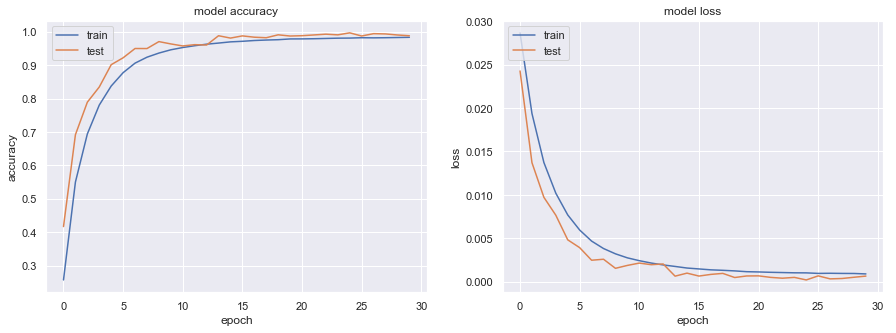

In [17]:
network_plot(history)

Let's train again with the same model, except this time, let's change the batch size to 16. First we rebuild the model to clear the weights then we immediately train.

In [16]:
%%time

num_filt_layers = [32,64,64]

inputs = Input(shape=ds.X_test[0].shape, name='Input')
x = inputs
for num_filt in num_filt_layers:
    x = Conv2D(filters=num_filt,
               kernel_size=(2,2),
               padding='same', 
               input_shape=ds.X_test[0].shape,
               data_format="channels_last")(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(len(ds.y_classes), activation='softmax')(x) 

cnn = Model(inputs=inputs, outputs=predictions)

cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = network_fit(cnn, 
                      datagen, 
                      ds.X_train, 
                      ds.y_train_ohe, 
                      ds.X_test, 
                      ds.y_test_ohe, 
                      epochs=epochs, 
                      batch_size=16, 
                      patience=patience, 
                      verbose=verbose
)

Epoch 1/300
4350/4350 [==============================] - 99s 23ms/step - loss: 0.0209 - acc: 0.4915 - val_loss: 0.0104 - val_acc: 0.7741
Epoch 2/300
4350/4350 [==============================] - 98s 22ms/step - loss: 0.0099 - acc: 0.7866 - val_loss: 0.0049 - val_acc: 0.8989
Epoch 3/300
4350/4350 [==============================] - 98s 23ms/step - loss: 0.0062 - acc: 0.8717 - val_loss: 0.0035 - val_acc: 0.9298
Epoch 4/300
4350/4350 [==============================] - 100s 23ms/step - loss: 0.0048 - acc: 0.9047 - val_loss: 0.0025 - val_acc: 0.9491
Epoch 5/300
4350/4350 [==============================] - 101s 23ms/step - loss: 0.0039 - acc: 0.9239 - val_loss: 0.0025 - val_acc: 0.9539
Epoch 6/300
4350/4350 [==============================] - 101s 23ms/step - loss: 0.0035 - acc: 0.9340 - val_loss: 0.0025 - val_acc: 0.9537
Epoch 7/300
4350/4350 [==============================] - 103s 24ms/step - loss: 0.0033 - acc: 0.9375 - val_loss: 0.0025 - val_acc: 0.9549
Epoch 8/300
4350/4350 [==============

After running for about 36 minutes, we were able to achieve a validation accuracy of 0.9606. Let's visualize how our model converged using <strong>network_plot</strong>.

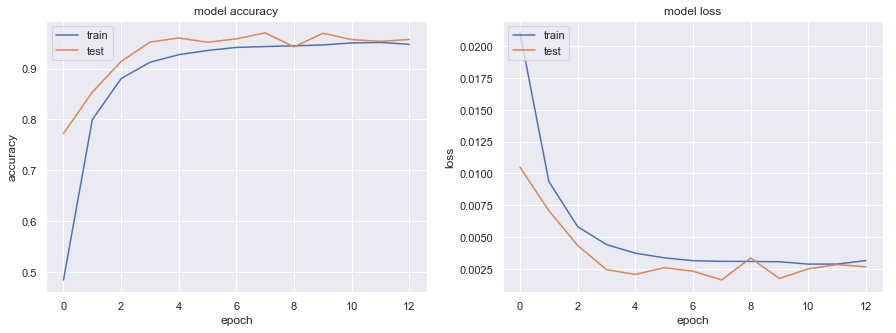

In [18]:
network_plot(history)

Although we ran our training for a total of 300 epochs, our model converged and activated an early stop at 21 epochs. As mentioned previously, we were able to accomplish a validation accuracy of 0.9609, but we think we can do better. Let's try another model.

<em> 
    <strong>[20 points]</strong> Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture). Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras).
</em>


For our second architecture we decided to use the Xception styled model that we implemented in class. We decided to test this model on our dataset because of its success on the Fashion MNIST dataset.

In [21]:
# Xception style architecture

l2_lambda = 0.000001
shape = ds.X_train[0].shape

input_holder = Input(shape=shape)

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = shape,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)


x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = SeparableConv2D(filters=32,
               input_shape = shape,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])

x = SeparableConv2D(filters=32,
               input_shape = shape,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])


# x = Activation("relu")(x_split)

# x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x_split)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(len(ds.y_classes),activation="softmax")(x)

xception = Model(inputs=input_holder,outputs=x)

xception.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

xception.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 16, 16, 32)   9248        max_pooling2d_7[0][0]       

Okay, after printing out a summary of Xception, let's train the model with <strong>network_fit</strong> again.

In [25]:
%%time

history = network_fit(xception, 
                      datagen, 
                      ds.X_train, 
                      ds.y_train_ohe, 
                      ds.X_test, 
                      ds.y_test_ohe, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      patience=patience,
                      verbose=verbose
)

Epoch 1/300
543/543 [==============================] - 64s 118ms/step - loss: 2.3783 - acc: 0.2851 - val_loss: 1.0886 - val_acc: 0.6785
Epoch 2/300
543/543 [==============================] - 63s 116ms/step - loss: 1.2552 - acc: 0.5848 - val_loss: 0.6497 - val_acc: 0.7959
Epoch 3/300
543/543 [==============================] - 63s 116ms/step - loss: 0.8839 - acc: 0.6999 - val_loss: 0.4073 - val_acc: 0.8756
Epoch 4/300
543/543 [==============================] - 63s 116ms/step - loss: 0.6957 - acc: 0.7596 - val_loss: 0.3168 - val_acc: 0.9068
Epoch 5/300
543/543 [==============================] - 63s 115ms/step - loss: 0.5763 - acc: 0.8013 - val_loss: 0.2295 - val_acc: 0.9320
Epoch 6/300
543/543 [==============================] - 63s 116ms/step - loss: 0.4900 - acc: 0.8318 - val_loss: 0.1689 - val_acc: 0.9499
Epoch 7/300
543/543 [==============================] - 63s 116ms/step - loss: 0.4222 - acc: 0.8531 - val_loss: 0.1754 - val_acc: 0.9410
Epoch 8/300
543/543 [===========================

TALK ABOUT CHANGES FROM BEFORE

After running for about 47 minutes, we were able to achieve a validation accuracy of 0.9959. Let's visualize how our model converged using <strong>network_plot</strong>.

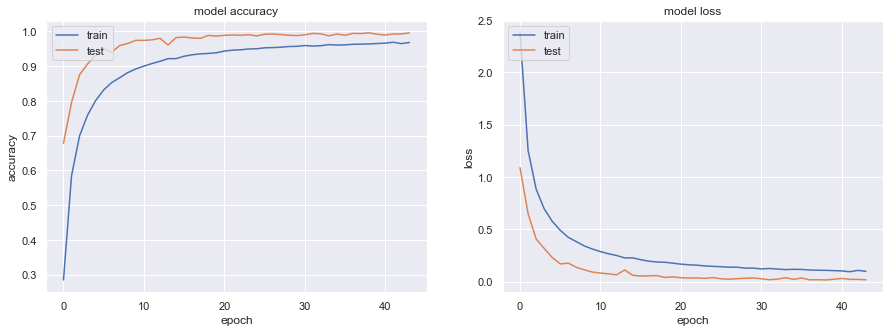

In [26]:
network_plot(history)

TALK ABOUT CHANGES FROM BEFORE

REWRITE: Although we ran our training for a total of 300 epochs, our model converged and activated an early stop at 44 epochs. As mentioned previously, we were able to accomplish a validation accuracy of 0.9959, but we think we can do better. Let's try another model. THEN WE RUN AGAIN

In [22]:
%%time

input_holder = Input(shape=shape)

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = shape,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)


x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = SeparableConv2D(filters=32,
               input_shape = shape,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])

x = SeparableConv2D(filters=32,
               input_shape = shape,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])


# x = Activation("relu")(x_split)

# x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x_split)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(len(ds.y_classes),activation="softmax")(x)

xception = Model(inputs=input_holder,outputs=x)

xception.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

history = network_fit(xception, 
                      datagen, 
                      ds.X_train, 
                      ds.y_train_ohe, 
                      ds.X_test, 
                      ds.y_test_ohe, 
                      epochs=epochs, 
                      batch_size=16, 
                      patience=patience,
                      verbose=verbose
)

Epoch 1/300
4350/4350 [==============================] - 89s 21ms/step - loss: 1.6928 - acc: 0.4739 - val_loss: 0.5494 - val_acc: 0.8189
Epoch 2/300
4350/4350 [==============================] - 88s 20ms/step - loss: 0.7496 - acc: 0.7455 - val_loss: 0.2999 - val_acc: 0.9049
Epoch 3/300
4350/4350 [==============================] - 89s 20ms/step - loss: 0.5332 - acc: 0.8156 - val_loss: 0.1816 - val_acc: 0.9439
Epoch 4/300
4350/4350 [==============================] - 90s 21ms/step - loss: 0.4293 - acc: 0.8518 - val_loss: 0.1517 - val_acc: 0.9532
Epoch 5/300
4350/4350 [==============================] - 91s 21ms/step - loss: 0.3718 - acc: 0.8725 - val_loss: 0.1697 - val_acc: 0.9433
Epoch 6/300
4350/4350 [==============================] - 93s 21ms/step - loss: 0.3263 - acc: 0.8889 - val_loss: 0.1285 - val_acc: 0.9538
Epoch 7/300
4350/4350 [==============================] - 94s 22ms/step - loss: 0.2983 - acc: 0.8996 - val_loss: 0.0795 - val_acc: 0.9744
Epoch 8/300
4350/4350 [==================

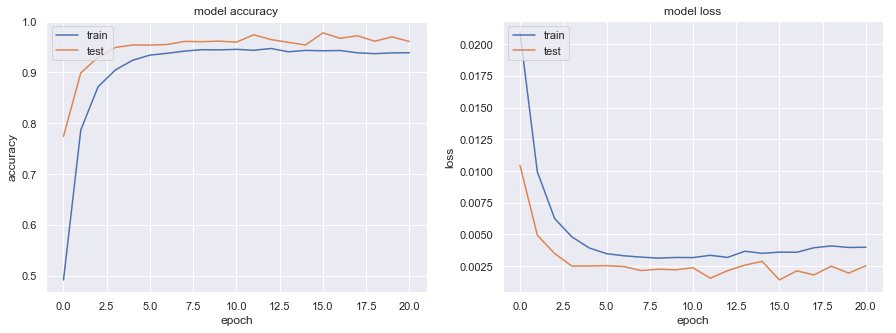

In [18]:
network_plot(history)

<em> 
    <strong>[15 points] </strong>Visualize the final results of the CNNs and interpret the performance. Use proper statistics as appropriate, especially for comparing models. 
</em>

In the next few cells, we call <strong>network_predict</strong> and <strong>network_summarize</strong> on our networks. We recieve our model's accuracy and confusion matrix, and, additionally, we get the receiver operating characteristic data to later compare the model's directly.

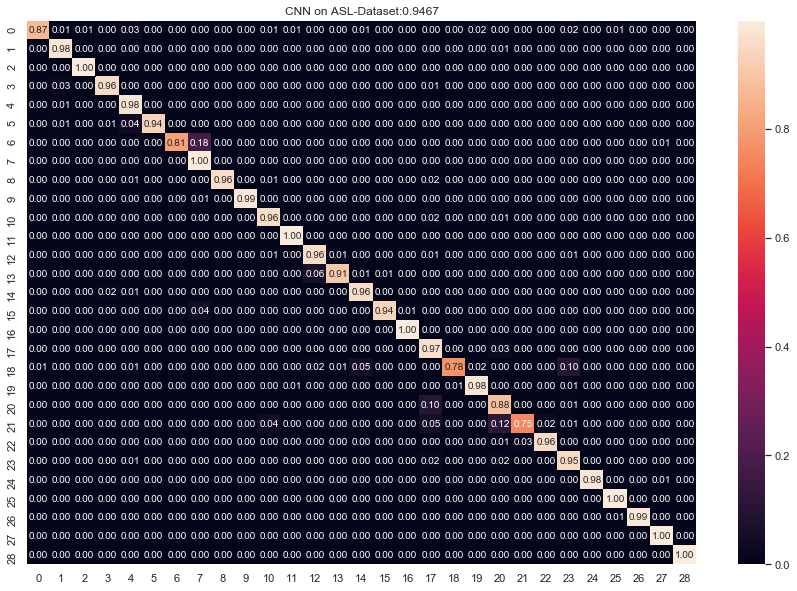

In [14]:
acc, fpr_cnn, tpr_cnn, roc_auc_cnn = network_predict(cnn, ds.X_test, ds.y_test_ohe)

network_summarize(cnn, ds.X_test, ds.y_test_value, title_text='CNN on ASL-Dataset:')

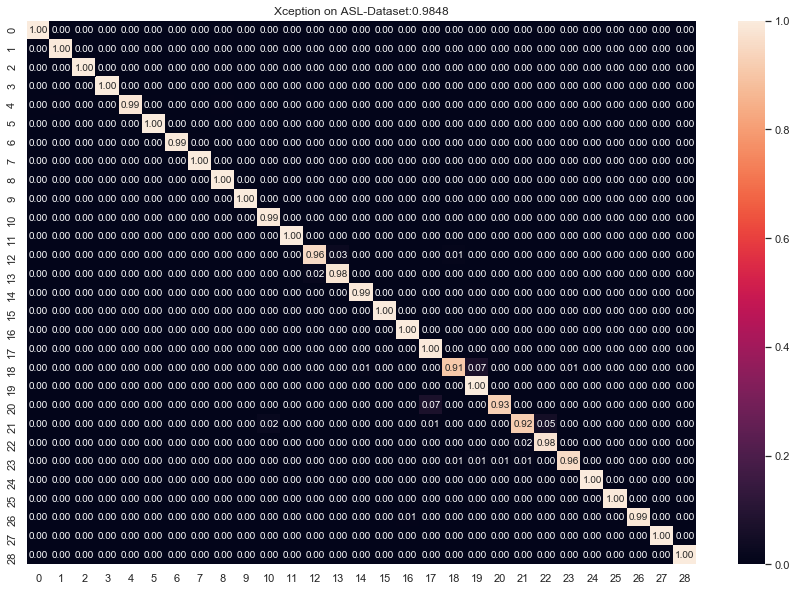

In [23]:
acc, fpr_xception, tpr_xception, roc_auc_xception = network_predict(xception, ds.X_test, ds.y_test_ohe)

network_summarize(xception, ds.X_test, ds.y_test_value, title_text='Xception on ASL-Dataset:')

It's a close call, but the <strong>Xception-style</strong> architecture actually outperforms our other <strong>CNN</strong> model.

<em> 
    <strong>[10 points]</strong> Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  
</em>

Okay! Time to compare out model's to an MLP. First, let's build a quick MLP framework.

In [24]:
shape = ds.X_train[0].shape

mlp = Sequential()
mlp.add( Reshape((ds.X_train[0].flatten().shape), input_shape=shape, name='Reshape') )
mlp.add( Dense(units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(len(ds.y_classes)) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Reshape (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               307300    
_________________________________________________________________
dense_12 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_13 (Dense)             (None, 29)                1479      
_________________________________________________________________
activation_7 (Activation)    (None, 29)                0         
Total params: 313,829
Trainable params: 313,829
Non-trainable params: 0
_________________________________________________________________


Hmm. We've pretty much seen everything above before. The most notable mention is that the MLP reshapes the 2D input data into linearized numpy vectors. This is so the model can properly handle the images. 

Otherwise, you know the drill, let's go ahead and train our model.

In [25]:
%%time

history = network_fit(mlp, 
                      datagen, 
                      ds.X_train, 
                      ds.y_train_ohe, 
                      ds.X_test, 
                      ds.y_test_ohe, 
                      epochs = epochs, 
                      batch_size=16, 
                      patience=patience,
                      verbose=verbose
)

Epoch 1/300
4350/4350 [==============================] - 48s 11ms/step - loss: 0.0322 - acc: 0.1120 - val_loss: 0.0299 - val_acc: 0.2097
Epoch 2/300
4350/4350 [==============================] - 47s 11ms/step - loss: 0.0299 - acc: 0.2213 - val_loss: 0.0275 - val_acc: 0.3013
Epoch 3/300
4350/4350 [==============================] - 47s 11ms/step - loss: 0.0286 - acc: 0.2695 - val_loss: 0.0268 - val_acc: 0.3198
Epoch 4/300
4350/4350 [==============================] - 47s 11ms/step - loss: 0.0278 - acc: 0.2969 - val_loss: 0.0258 - val_acc: 0.3499
Epoch 5/300
4350/4350 [==============================] - 47s 11ms/step - loss: 0.0272 - acc: 0.3203 - val_loss: 0.0250 - val_acc: 0.3864
Epoch 6/300
4350/4350 [==============================] - 47s 11ms/step - loss: 0.0267 - acc: 0.3334 - val_loss: 0.0241 - val_acc: 0.4024
Epoch 7/300
4350/4350 [==============================] - 47s 11ms/step - loss: 0.0265 - acc: 0.3431 - val_loss: 0.0258 - val_acc: 0.3539
Epoch 8/300
4350/4350 [==================

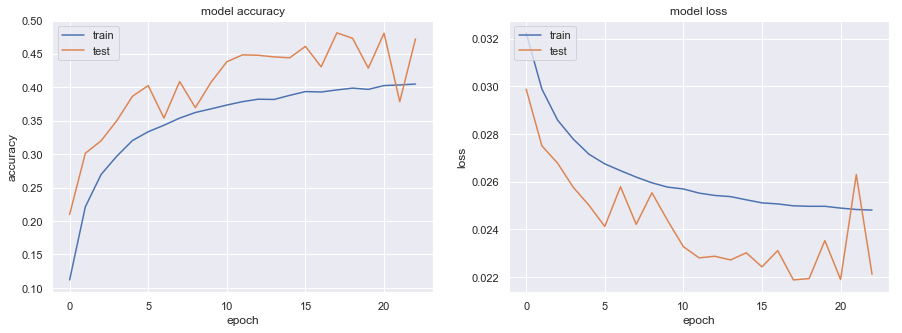

In [26]:
network_plot(history)

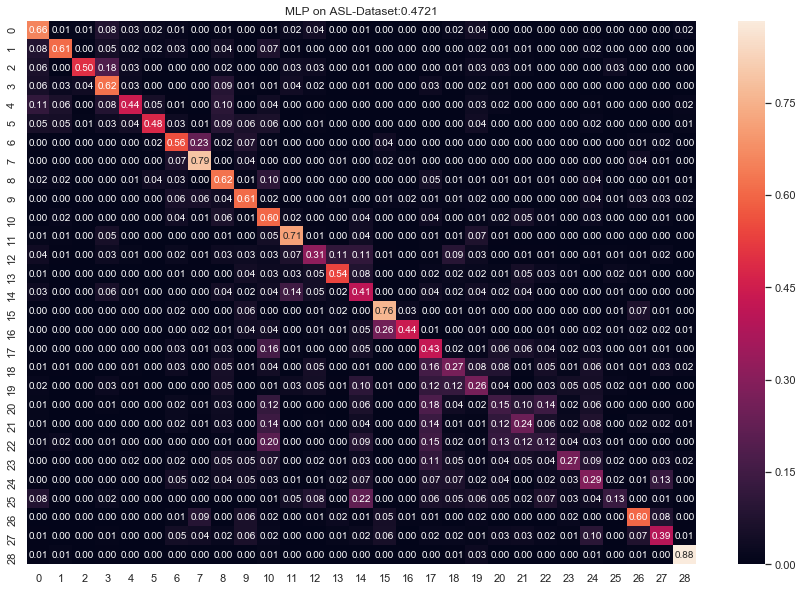

In [27]:
acc, fpr_mlp, tpr_mlp, roc_auc_mlp = network_predict(mlp, ds.X_test, ds.y_test_ohe)

network_summarize(mlp, ds.X_test, ds.y_test_value, title_text='MLP on ASL-Dataset:')

Before commenting on the last few cells, let's just go ahead and display the ROC for our two CNN's and our MLP.

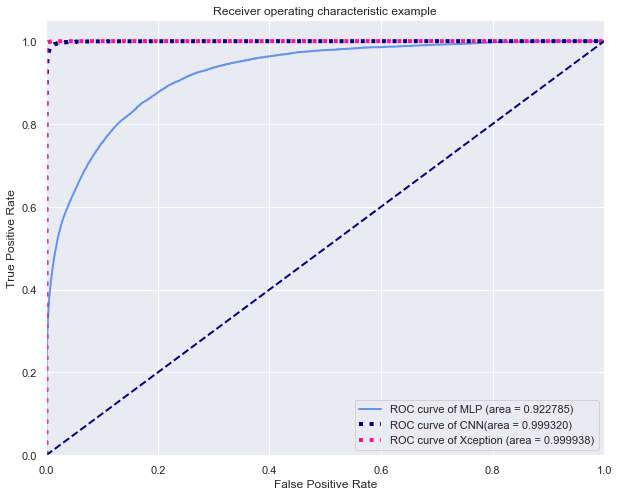

In [28]:
plt.figure(figsize=(10,8))
lw = 2

# MLP
plt.plot(fpr_mlp, tpr_mlp, color='cornflowerblue',
         lw=lw, label='ROC curve of MLP (area = %0.6f)' % roc_auc_mlp)

# CNN 1
plt.plot(fpr_cnn, tpr_cnn, color='navy', linestyle=':', linewidth=4,
         lw=lw, label='ROC curve of CNN(area = %0.6f)' % roc_auc_cnn)

# CNN 2
plt.plot(fpr_xception, tpr_xception, color='deeppink', linestyle=':', linewidth=4,
         lw=lw, label='ROC curve of Xception (area = %0.6f)' % roc_auc_xception)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Explain how we dont really care for class differences. as a result, micro ROC is a great way to capture the differences in the graphs. Additionally, since we have no preference over false positives or true negatives, the best way to rate the graphs is by taking the area under the curve.

## Exceptional Work (10 points total)

<em> 
    <strong>[10 points]</strong>You have free reign to provide additional analyses. 
One idea (required for 7000 level students): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training from scratch in terms of classification performance.
</em>

For our pre-training weights we decided to import Xception.

In [29]:
%%time

from keras.applications import Xception
from keras.applications.xception import preprocess_input

# load only convolutional layers of Xception:
xception_no_top = Xception(weights='imagenet', include_top=False)

x_train_pre = preprocess_input(ds.X_train)
X_test_pre = preprocess_input(ds.X_test)

# train on half the data, to save a few hours
x_train_xception = xception_no_top.predict(x_train_pre)
x_test_xception = xception_no_top.predict(X_test_pre)

83689472/83683744 [==============================] - 47s 1us/step
Wall time: 9min 34s


This is the shape of where the weights were cut off from Xception.

In [30]:
shape = x_train_xception[0].shape
print(shape)

(1, 1, 2048)


Let's take those weights and put them in 

In [31]:
inputs = Input(shape=shape)
x = Flatten()(inputs)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
predictions = Dense(len(ds.y_classes), activation='softmax', kernel_initializer='glorot_uniform')(x)

pre = Model(inputs=inputs, outputs=predictions)

pre.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

pre.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 200)               409800    
_________________________________________________________________
dense_15 (Dense)             (None, 29)                5829      
Total params: 415,629
Trainable params: 415,629
Non-trainable params: 0
_________________________________________________________________


Mention the high number of epochs and the high patience that we used

In [32]:
%%time

epochs = 3000
batch_size = 32
patience = 30
verbose = 0

y_train_ohe_xception = ds.y_train_ohe[:x_train_xception.shape[0]]

history = pre.fit(x_train_xception,
                    y_train_ohe_xception,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=verbose,
                    validation_data=(x_test_xception, ds.y_test_ohe[:x_test_xception.shape[0]]),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=patience)]
)

Wall time: 1h 33min 8s


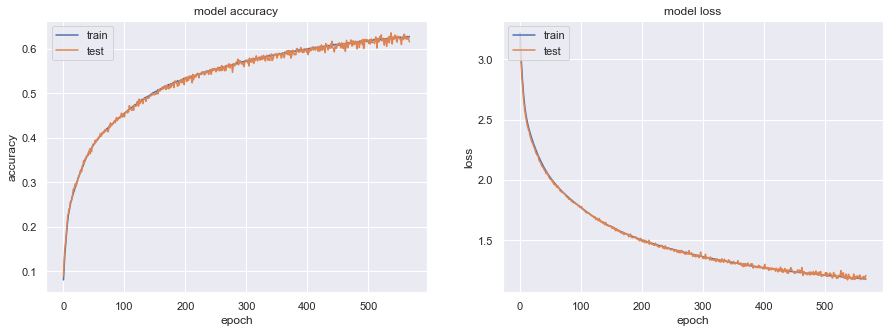

In [33]:
network_plot(history)

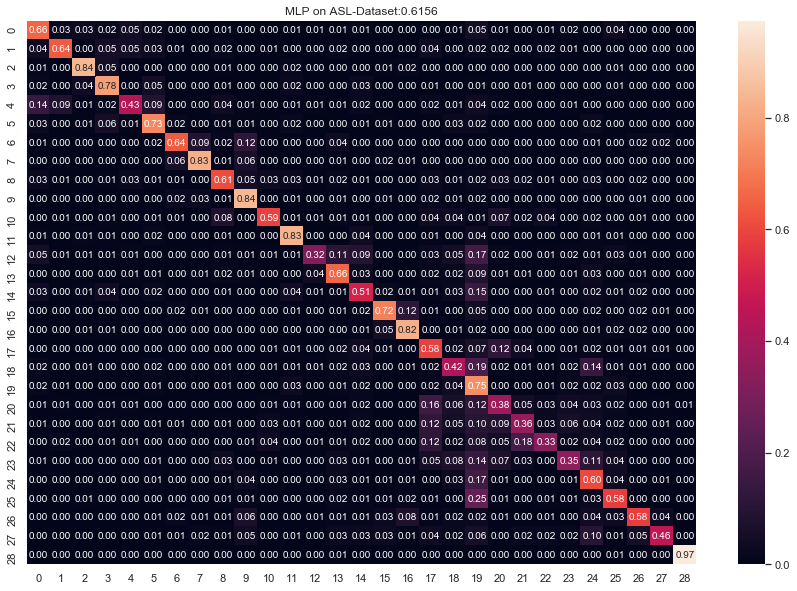

In [34]:
acc, fpr_pre, tpr_pre, roc_auc_pre = network_predict(pre, x_test_xception, ds.y_test_ohe[:x_test_xception.shape[0]])

network_summarize(pre, x_test_xception, ds.y_test_value, title_text='MLP on ASL-Dataset:')

After training for: we got this.

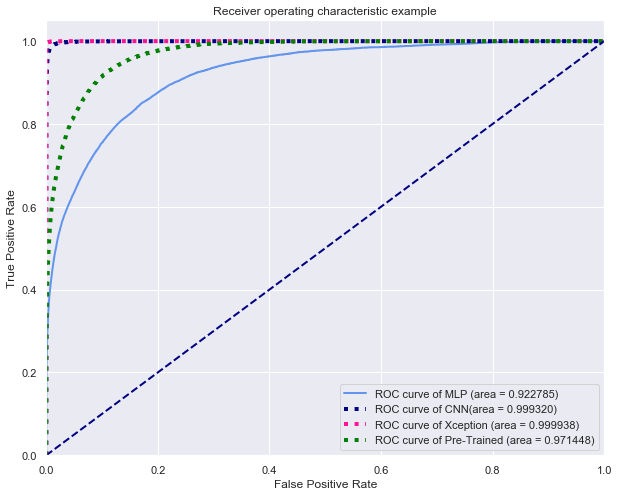

In [35]:
plt.figure(figsize=(10,8))
lw = 2

# MLP
plt.plot(fpr_mlp, tpr_mlp, color='cornflowerblue',
         lw=lw, label='ROC curve of MLP (area = %0.6f)' % roc_auc_mlp)

# CNN
plt.plot(fpr_cnn, tpr_cnn, color='navy', linestyle=':', linewidth=4,
         lw=lw, label='ROC curve of CNN(area = %0.6f)' % roc_auc_cnn)

# Xception
plt.plot(fpr_xception, tpr_xception, color='deeppink', linestyle=':', linewidth=4,
         lw=lw, label='ROC curve of Xception (area = %0.6f)' % roc_auc_xception)

# Pre-Trained
plt.plot(fpr_pre, tpr_pre, color='green', linestyle=':', linewidth=4,
         lw=lw, label='ROC curve of Pre-Trained (area = %0.6f)' % roc_auc_pre)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Our Xception style model trained from scratch was best